In [1]:
import os
import cv2
import copy
import time
import random
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
from torch.cuda import amp

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, GroupKFold
from sklearn.metrics import roc_auc_score, f1_score

from tqdm.notebook import tqdm
from collections import defaultdict
import albumentations as A
from albumentations.pytorch import ToTensorV2

import timm
from pytorch_metric_learning import losses
import ShopeeDataset as SD

<span style="color: #0087e4; font-family: Segoe UI; font-size: 2.3em; font-weight: 300;">Training Configuration</span>

In [2]:
class CFG:
    seed = 42
    model_name = 'tf_efficientnet_b1'
    img_size = 128
    scheduler = 'CosineAnnealingLR'
    T_max = 10
    lr = 1e-5
    min_lr = 1e-6
    batch_size = 16
    weight_decay = 1e-6
    num_epochs = 30
    num_classes = 2
    embedding_size = 128
    n_fold = 2
    n_accumulate = 4
    temperature = 0.1
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
TRAIN_DIR = 'C:/Users/linus/python_projects/deep_learning_for_image_analysis/cancer-classification-challenge-2023/train'
TEST_DIR = 'C:/Users/linus/python_projects/deep_learning_for_image_analysis/cancer-classification-challenge-2023/test'

<span style="color: #0087e4; font-family: Segoe UI; font-size: 2.3em; font-weight: 300;">Set Seed for Reproducibility</span>

In [4]:
def set_seed(seed = 42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    

set_seed(CFG.seed)

In [5]:
df_train = pd.read_csv('C:/Users/linus/python_projects/deep_learning_for_image_analysis/cancer-classification-challenge-2023/train.csv')
df_train['file_path'] = df_train.Name.apply(lambda x: os.path.join(TRAIN_DIR, x))
df_train.head(5)

,Name,Diagnosis,file_path
0,pat_009_ind_5214.jpg,1,C:/Users/linus/python_projects/deep_learning_f...
1,pat_009_ind_5365.jpg,1,C:/Users/linus/python_projects/deep_learning_f...
2,pat_009_ind_84.jpg,1,C:/Users/linus/python_projects/deep_learning_f...
3,pat_009_ind_1799.jpg,1,C:/Users/linus/python_projects/deep_learning_f...
4,pat_009_ind_7109.jpg,1,C:/Users/linus/python_projects/deep_learning_f...


In [6]:
le = LabelEncoder()
df_train.Diagnosis = le.fit_transform(df_train.Diagnosis)

<span style="color: #0087e4; font-family: Segoe UI; font-size: 2.3em; font-weight: 300;">Dataset Class</span>

<span style="color: #0087e4; font-family: Segoe UI; font-size: 2.3em; font-weight: 300;">Augmentations & Transforms</span>

In [7]:
data_transforms = {
    "train": A.Compose([
        #A.Resize(CFG.img_size, CFG.img_size),
        #A.HorizontalFlip(p=0.5),
        A.RandomCrop(width=60, height=60),
        A.Resize(128, 128),
        A.RandomBrightnessContrast(
                brightness_limit=(-0.1,0.1), 
                contrast_limit=(-0.1, 0.1), 
                p=0.5
            ),
        A.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
                max_pixel_value=255.0, 
                p=1.0
            ),
        ToTensorV2()], p=1.),
    
    "valid": A.Compose([
        A.Resize(CFG.img_size, CFG.img_size),
        A.Normalize(
                mean=[0.3949, 0.4938, 0.5553], 
                std=[0.1536, 0.1391, 0.1158], 
                max_pixel_value=255.0, 
                p=1.0
            ),
        ToTensorV2()], p=1.)
}

<span style="color: #0087e4; font-family: Segoe UI; font-size: 2.3em; font-weight: 300;">Training Function</span>

<p> Uses Automatic Mixed Precision to speed up training process and Gradient Accumulation to increase batch size<br>
Refer this <a href="https://www.kaggle.com/c/cassava-leaf-disease-classification/discussion/199631">Discussion</a> to know more about mixed precision training <br>
Refer this <a href="https://www.kaggle.com/c/cassava-leaf-disease-classification/discussion/217133">Discussion</a> to know more about gradient accumulation</p>

In [8]:
def train_model(model, criterion, optimizer, scheduler, num_epochs, dataloaders, dataset_sizes, device, fold):
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = np.inf
    history = defaultdict(list)
    scaler = amp.GradScaler()

    for step, epoch in enumerate(range(1,num_epochs+1)):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train','valid']:
            if(phase == 'train'):
                model.train() # Set model to training mode
            else:
                model.eval() # Set model to evaluation mode
            
            running_loss = 0.0
            
            # Iterate over data
            for inputs,labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(CFG.device)
                labels = labels.to(CFG.device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    with amp.autocast(enabled=True):
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                        loss = loss / CFG.n_accumulate
                    
                    # backward only if in training phase
                    if phase == 'train':
                        scaler.scale(loss).backward()

                    # optimize only if in training phase
                    if phase == 'train' and (step + 1) % CFG.n_accumulate == 0:
                        scaler.step(optimizer)
                        scaler.update()
                        scheduler.step()
                        
                        # zero the parameter gradients
                        optimizer.zero_grad()


                running_loss += loss.item()*inputs.size(0)
            
            epoch_loss = running_loss/dataset_sizes[phase]            
            history[phase + ' loss'].append(epoch_loss)

            print('{} Loss: {:.4f}'.format(
                phase, epoch_loss))
            
            # deep copy the model
            if phase=='valid' and epoch_loss <= best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                PATH = f"Fold{fold}_{best_loss}_epoch_{epoch}.bin"
                torch.save(model.state_dict(), PATH)

        print()

    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best Loss ",best_loss)

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

In [9]:
def run_fold(model, criterion, optimizer, scheduler, device, fold, num_epochs=10):
    df_train['fold'] = np.random.randint(0, 2, df_train.shape[0])
    valid_df = df_train[df_train.fold == fold]
    train_df = df_train[df_train.fold != fold]
    
    
    train_data = SD.ShopeeDataset(TRAIN_DIR, train_df, transforms=data_transforms["train"])
    valid_data = SD.ShopeeDataset(TRAIN_DIR, valid_df, transforms=data_transforms["valid"])
    
    dataset_sizes = {
        'train' : len(train_data),
        'valid' : len(valid_data)
    }
    
    train_loader = DataLoader(dataset=train_data, batch_size=CFG.batch_size, num_workers=4, pin_memory=True, shuffle=True)
    valid_loader = DataLoader(dataset=valid_data, batch_size=CFG.batch_size, num_workers=4, pin_memory=True, shuffle=False)
    
    dataloaders = {
        'train' : train_loader,
        'valid' : valid_loader
    }

    model, history = train_model(model, criterion, optimizer, scheduler, num_epochs, dataloaders, dataset_sizes, device, fold)
    
    return model, history

<span style="color: #0087e4; font-family: Segoe UI; font-size: 2.3em; font-weight: 300;">Load Model</span>

In [10]:
model = timm.create_model(CFG.model_name, pretrained=True)
in_features = model.classifier.in_features
model.classifier = nn.Linear(in_features, CFG.embedding_size)

out = model(torch.randn(1, 3, CFG.img_size, CFG.img_size))
print(f'Embedding shape: {out.shape}')

model.to(CFG.device);

Embedding shape: torch.Size([1, 128])


<span style="color: #0087e4; font-family: Segoe UI; font-size: 2.3em; font-weight: 300;">Custom Implementation</span>

<span style="color: #000508; font-family: Segoe UI; font-size: 2.0em; font-weight: 300;">Implementation converted to Pytorch from <a href="https://www.kaggle.com/dimitreoliveira/cassava-leaf-supervised-contrastive-learning">this</a> amazing notebook</span>

In [11]:
class SupervisedContrastiveLoss(nn.Module):
    def __init__(self, temperature=0.1):
        super(SupervisedContrastiveLoss, self).__init__()
        self.temperature = temperature

    def forward(self, feature_vectors, labels):
        # Normalize feature vectors
        feature_vectors_normalized = F.normalize(feature_vectors, p=2, dim=1)
        # Compute logits
        logits = torch.div(
            torch.matmul(
                feature_vectors_normalized, torch.transpose(feature_vectors_normalized, 0, 1)
            ),
            self.temperature,
        )
        return losses.NTXentLoss(temperature=0.07)(logits, torch.squeeze(labels))

Version 5: Loss from Pytorch Metric Learning Library <br>
Version 6: Custom Implementation

In [12]:
#criterion = SupervisedContrastiveLoss(temperature=CFG.temperature).to(CFG.device) # Custom Implementation
criterion = losses.SupConLoss(temperature=CFG.temperature).to(CFG.device)
optimizer = optim.Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr)

<span style="color: #0087e4; font-family: Segoe UI; font-size: 2.3em; font-weight: 300;">Run Fold 0</span>

In [13]:
model, history = run_fold(model, criterion, optimizer, scheduler, device=CFG.device, fold=0, num_epochs=CFG.num_epochs)

Epoch 1/30
----------


  0%|          | 0/2299 [00:00<?, ?it/s]

train Loss: 0.7836


  0%|          | 0/2291 [00:00<?, ?it/s]

valid Loss: 0.0014

Epoch 2/30
----------


  0%|          | 0/2299 [00:00<?, ?it/s]

train Loss: 0.7856


  0%|          | 0/2291 [00:00<?, ?it/s]

valid Loss: 0.0014

Epoch 3/30
----------


  0%|          | 0/2299 [00:00<?, ?it/s]

train Loss: 0.7842


  0%|          | 0/2291 [00:00<?, ?it/s]

valid Loss: 0.0013

Epoch 4/30
----------


  0%|          | 0/2299 [00:00<?, ?it/s]

c:\users\linus\python_projects\deep_learning_for_image_analysis\.venv\lib\site-packages\torch\optim\lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


train Loss: 0.7289


  0%|          | 0/2291 [00:00<?, ?it/s]

valid Loss: 0.0012

Epoch 5/30
----------


  0%|          | 0/2299 [00:00<?, ?it/s]

train Loss: 0.6893


  0%|          | 0/2291 [00:00<?, ?it/s]

valid Loss: 0.0012

Epoch 6/30
----------


  0%|          | 0/2299 [00:00<?, ?it/s]

train Loss: 0.6890


  0%|          | 0/2291 [00:00<?, ?it/s]

valid Loss: 0.0012

Epoch 7/30
----------


  0%|          | 0/2299 [00:00<?, ?it/s]

train Loss: 0.6888


  0%|          | 0/2291 [00:00<?, ?it/s]

valid Loss: 0.0012

Epoch 8/30
----------


  0%|          | 0/2299 [00:00<?, ?it/s]

train Loss: 0.6826


  0%|          | 0/2291 [00:00<?, ?it/s]

valid Loss: 0.0012

Epoch 9/30
----------


  0%|          | 0/2299 [00:00<?, ?it/s]

train Loss: 0.6814


  0%|          | 0/2291 [00:00<?, ?it/s]

valid Loss: 0.0012

Epoch 10/30
----------


  0%|          | 0/2299 [00:00<?, ?it/s]

train Loss: 0.6817


  0%|          | 0/2291 [00:00<?, ?it/s]

valid Loss: 0.0012

Epoch 11/30
----------


  0%|          | 0/2299 [00:00<?, ?it/s]

train Loss: 0.6810


  0%|          | 0/2291 [00:00<?, ?it/s]

valid Loss: 0.0012

Epoch 12/30
----------


  0%|          | 0/2299 [00:00<?, ?it/s]

train Loss: 0.6785


  0%|          | 0/2291 [00:00<?, ?it/s]

valid Loss: 0.0012

Epoch 13/30
----------


  0%|          | 0/2299 [00:00<?, ?it/s]

train Loss: 0.6785


  0%|          | 0/2291 [00:00<?, ?it/s]

valid Loss: 0.0012

Epoch 14/30
----------


  0%|          | 0/2299 [00:00<?, ?it/s]

train Loss: 0.6787


  0%|          | 0/2291 [00:00<?, ?it/s]

valid Loss: 0.0012

Epoch 15/30
----------


  0%|          | 0/2299 [00:00<?, ?it/s]

train Loss: 0.6784


  0%|          | 0/2291 [00:00<?, ?it/s]

valid Loss: 0.0012

Epoch 16/30
----------


  0%|          | 0/2299 [00:00<?, ?it/s]

train Loss: 0.6766


  0%|          | 0/2291 [00:00<?, ?it/s]

valid Loss: 0.0012

Epoch 17/30
----------


  0%|          | 0/2299 [00:00<?, ?it/s]

train Loss: 0.6770


  0%|          | 0/2291 [00:00<?, ?it/s]

valid Loss: 0.0012

Epoch 18/30
----------


  0%|          | 0/2299 [00:00<?, ?it/s]

train Loss: 0.6769


  0%|          | 0/2291 [00:00<?, ?it/s]

valid Loss: 0.0012

Epoch 19/30
----------


  0%|          | 0/2299 [00:00<?, ?it/s]

train Loss: 0.6769


  0%|          | 0/2291 [00:00<?, ?it/s]

valid Loss: 0.0012

Epoch 20/30
----------


  0%|          | 0/2299 [00:00<?, ?it/s]

train Loss: 0.6749


  0%|          | 0/2291 [00:00<?, ?it/s]

valid Loss: 0.0012

Epoch 21/30
----------


  0%|          | 0/2299 [00:00<?, ?it/s]

train Loss: 0.6748


  0%|          | 0/2291 [00:00<?, ?it/s]

valid Loss: 0.0012

Epoch 22/30
----------


  0%|          | 0/2299 [00:00<?, ?it/s]

train Loss: 0.6753


  0%|          | 0/2291 [00:00<?, ?it/s]

valid Loss: 0.0012

Epoch 23/30
----------


  0%|          | 0/2299 [00:00<?, ?it/s]

train Loss: 0.6750


  0%|          | 0/2291 [00:00<?, ?it/s]

valid Loss: 0.0012

Epoch 24/30
----------


  0%|          | 0/2299 [00:00<?, ?it/s]

train Loss: 0.6748


  0%|          | 0/2291 [00:00<?, ?it/s]

valid Loss: 0.0012

Epoch 25/30
----------


  0%|          | 0/2299 [00:00<?, ?it/s]

train Loss: 0.6735


  0%|          | 0/2291 [00:00<?, ?it/s]

valid Loss: 0.0012

Epoch 26/30
----------


  0%|          | 0/2299 [00:00<?, ?it/s]

train Loss: 0.6744


  0%|          | 0/2291 [00:00<?, ?it/s]

valid Loss: 0.0012

Epoch 27/30
----------


  0%|          | 0/2299 [00:00<?, ?it/s]

train Loss: 0.6741


  0%|          | 0/2291 [00:00<?, ?it/s]

valid Loss: 0.0012

Epoch 28/30
----------


  0%|          | 0/2299 [00:00<?, ?it/s]

train Loss: 0.6739


  0%|          | 0/2291 [00:00<?, ?it/s]

valid Loss: 0.0012

Epoch 29/30
----------


  0%|          | 0/2299 [00:00<?, ?it/s]

train Loss: 0.6734


  0%|          | 0/2291 [00:00<?, ?it/s]

valid Loss: 0.0012

Epoch 30/30
----------


  0%|          | 0/2299 [00:00<?, ?it/s]

train Loss: 0.6731


  0%|          | 0/2291 [00:00<?, ?it/s]

valid Loss: 0.0012

Training complete in 1h 4m 47s
Best Loss  0.0011776589466450846


<span style="color: #0087e4; font-family: Segoe UI; font-size: 2.3em; font-weight: 300;">Visualize Training & Validation Metrics</span>

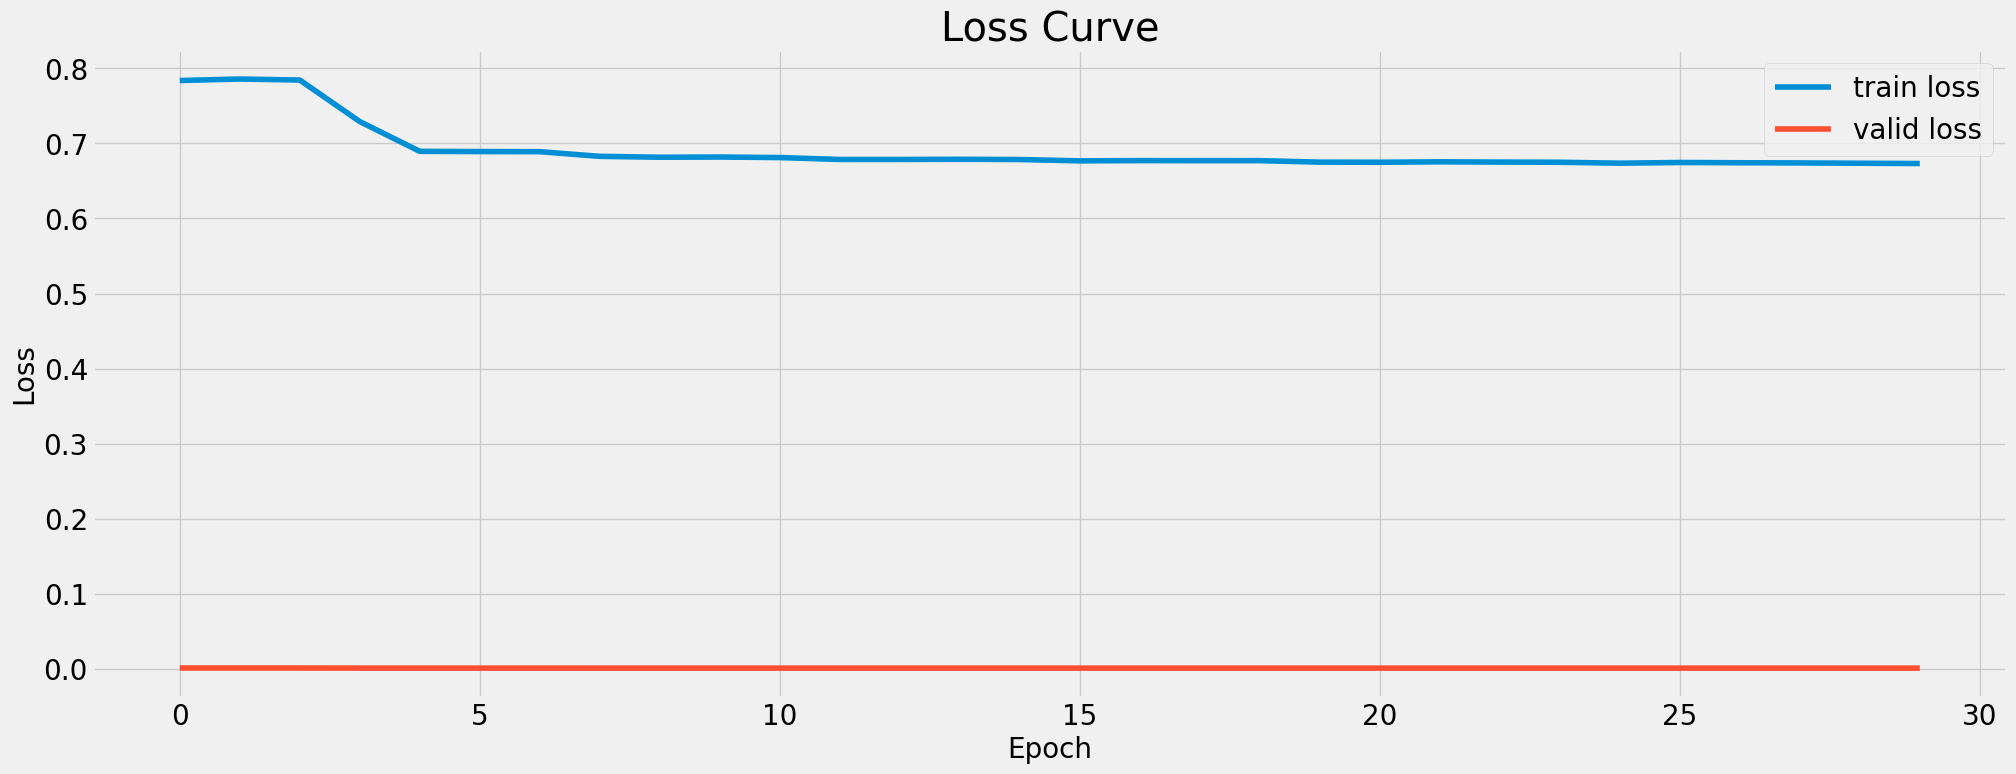

In [14]:
plt.style.use('fivethirtyeight')
plt.rcParams["font.size"] = "20"
fig = plt.figure(figsize=(22,8))
epochs = list(range(CFG.num_epochs))
plt.plot(epochs, history['train loss'], label='train loss')
plt.plot(epochs, history['valid loss'], label='valid loss')
plt.ylabel('Loss', fontsize=20)
plt.xlabel('Epoch', fontsize=20)
plt.legend()
plt.title('Loss Curve');
plt.show()

In [23]:
model.classifier = nn.Sequential(
    nn.Linear(1280, 2)
    #nn.ReLU(),
    #nn.Linear(512, 2)
)

for param in model.parameters():
    param.requires_grad = True #False

for param in model.classifier.parameters():
    param.requires_grad = True



In [24]:
model = model.to(CFG.device)

In [25]:
import os
import torch
import glob
import torchvision
import torch.nn as nn
import pandas as pd
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

In [26]:
class OralCancerDataset(Dataset):
    """__init__ and __len__ functions are the same as in TorchvisionDataset"""

    def __init__(self, path_to_images, path_to_csv = None, transform=None):

        # Passing the path to the train csv file reads the data from the csv with the labels
        # If None is passes insted only the images in the image folder is loaded (wich is useful for the test set)

        self.path_to_images = path_to_images
        self.path_to_csv = path_to_csv
        self.transform = transform

        if self.path_to_csv is not None:
            self.df = pd.read_csv(self.path_to_csv)

    def __len__(self):
        if self.path_to_csv:
            return len(self.df)
        else:
            return len(glob.glob(self.path_to_images + '/*.jpg'))

    def __getitem__(self, idx):
        if self.path_to_csv:
            data = self.df.iloc[idx]
            img_path = os.path.join(self.path_to_images, data['Name'])
            #image = torchvision.io.read_image(img_path)
            image = Image.open(img_path)
            label = data['Diagnosis']

            # You can input torchvision (or other) transforms and directly augment the data
            if self.transform:
                image = self.transform(image)
            # ..

            return image, label

        else:
            name = 'image_' + str(idx) + '.jpg'
            #image = torchvision.io.read_image(os.path.join(self.path_to_images, name), -1)
            image = Image.open(os.path.join(self.path_to_images, name))

            if self.transform:
                image = self.transform(image)

            return image, name

In [27]:
path_to_csv = 'C:/Users/linus/python_projects/deep_learning_for_image_analysis/cancer-classification-challenge-2023/train.csv'
path_to_train_images = 'C:/Users/linus/python_projects/deep_learning_for_image_analysis/cancer-classification-challenge-2023/train'
path_to_test_images = 'C:/Users/linus/python_projects/deep_learning_for_image_analysis/cancer-classification-challenge-2023/test'

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

train_dataset = OralCancerDataset(path_to_train_images, path_to_csv)

test_dataset = OralCancerDataset(path_to_test_images, None, transform_test)


generator1 = torch.Generator().manual_seed(42)
train_set, val_set = torch.utils.data.random_split(train_dataset, [int(len(train_dataset)*0.8), int(len(train_dataset)) - int(len(train_dataset)*0.8)], generator=generator1)

train_set.dataset.transform = transform
val_set.dataset.transform = transform


train_dataloader = DataLoader(train_set,
    batch_size=32,
    shuffle=True)

val_dataloader = DataLoader(val_set,
    batch_size=32,
    shuffle=True)

test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [28]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_loss = []
F1_score_train = []
val_loss = []
F1_score_val = []
epochs = []

In [ ]:
# Train the model
num_epochs = 15
for epoch in range(num_epochs):
    print("start training epoch:", epoch+1)
    model.train()
    running_loss = 0.0
    y_true = []
    y_pred = []
    for images, labels in train_dataloader:
        images = images.to(CFG.device)
        labels = labels.to(CFG.device)
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images.float())

        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.tolist())
        y_pred.extend(predicted.tolist())

        # Calculate the F1 score

        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Print the average loss for the epoch
    train_loss.append(running_loss/len(train_dataloader))
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_dataloader):.4f}")
    f1 = f1_score(y_true, y_pred, average='macro')
    print(f"Train F1 Score: {f1:.4f}")
    F1_score_train.append(f1)

    # Validation
    model.eval()
    y_true = []
    y_pred = []
    running_loss = 0
    with torch.no_grad():
        for images, labels in val_dataloader:
            images = images.to(CFG.device)
            labels = labels.to(CFG.device)
            outputs = model(images.float())
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.tolist())
            y_pred.extend(predicted.tolist())
    
    val_loss.append(running_loss/len(val_dataloader))
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(val_dataloader):.4f}")
    # Calculate the F1 score
    f1 = f1_score(y_true, y_pred, average='macro')
    print(f"Validation F1 Score: {f1:.4f}")
    F1_score_val.append(f1)
    epochs.append(epoch+1)

d = {'Name':[], 'Diagnosis':[]}
for images, name in test_dataloader:
    images = images.to(CFG.device)
    outputs = model(images.float())
    _, predicted = torch.max(outputs.data, 1)
    label = predicted.tolist()
    d['Name'].extend(name)
    d['Diagnosis'].extend(label)

df = pd.DataFrame(d)
df.to_csv('submission.csv', index = False)

start training epoch: 1
Epoch 1/15, Loss: 0.3497
Train F1 Score: 0.8204
Epoch 1/15, Loss: 0.2585
Validation F1 Score: 0.8738
start training epoch: 2
Epoch 2/15, Loss: 0.2471
Train F1 Score: 0.8840
Epoch 2/15, Loss: 0.2148
Validation F1 Score: 0.9018
start training epoch: 3
Epoch 3/15, Loss: 0.1968
Train F1 Score: 0.9113
Epoch 3/15, Loss: 0.2088
Validation F1 Score: 0.9068
start training epoch: 4
Epoch 4/15, Loss: 0.1594
Train F1 Score: 0.9294
Epoch 4/15, Loss: 0.1980
Validation F1 Score: 0.9099
start training epoch: 5


In [ ]:

plt.style.use('fivethirtyeight')



fig, (ax1, ax2) = plt.subplots(1, 2)
fig = plt.figure(figsize=(22,8))

ax1.set_title('loss')
ax1.set_xlabel('Epochs')
ax1.plot(epochs, train_loss, label='training loss')
ax1.plot(epochs, val_loss, label='val loss')
ax1.grid()
ax1.legend()

ax2.set_title('F1 score')
ax2.set_xlabel('Epochs')
ax2.plot(epochs, F1_score_train, label= 'Train F1')
ax2.plot(epochs, F1_score_val, label= 'Val F1')
ax2.grid()
ax2.legend()
#plt.savefig('Train_graph.png', dpi = 200)